In [1]:
!pip freeze | grep -E "qiskit|pyscf"

pyscf==2.8.0
qiskit==1.3.1
qiskit-aer==0.16.0
qiskit-algorithms==0.3.1
qiskit-experiments==0.8.1
qiskit-ibm-experiment==0.4.8
qiskit-ibm-provider==0.11.0
qiskit-ibm-runtime==0.34.0
qiskit-machine-learning==0.8.2
qiskit-nature==0.7.2


# Effect of measurement *shots* on VQE simulation

In [ ]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
from qiskit_algorithms import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, SPSA
from qiskit.circuit.library import TwoLocal
from qiskit_nature.second_q.formats import MoleculeInfo
from qiskit_nature.units import DistanceUnit as UnitsType
from qiskit_nature.second_q.drivers import ElectronicStructureDriver, PySCFDriver
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.mappers import (
    ParityMapper,
    JordanWignerMapper,
    BravyiKitaevMapper,
)
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import UCC, UCCSD, HartreeFock
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_aer import AerSimulator as Aer
from qiskit_aer.primitives import Estimator

In [3]:
molecule = MoleculeInfo(
    symbols=["H", "H"],
    coords=np.array([[0.0, 0.0, 0.0], [0.0, 0.0, 0.735]]),
    multiplicity=1,
    charge=0,
    units=UnitsType.ANGSTROM,
)

In [4]:
driver = PySCFDriver.from_molecule(molecule, basis="sto-3g")
problem = driver.run()

In [5]:
num_alpha_electrons = problem.num_alpha
num_beta_electrons = problem.num_beta
num_spin_orbitals = int(problem.num_spin_orbitals)

nuclear_rep_energy = problem.nuclear_repulsion_energy
print("number of alpha electrons: ", num_alpha_electrons)
print("number of beta electrons: ", num_beta_electrons)
print("number of spin orbitals: ", num_spin_orbitals)
print("nuclear repulsion energy: ", nuclear_rep_energy)

number of alpha electrons:  1
number of beta electrons:  1
number of spin orbitals:  4
nuclear repulsion energy:  0.7199689944489797


In [6]:
# Define the active space around the Fermi level
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=2,  # Number of electrons in our active space
    num_spatial_orbitals=2,  # Number of orbitals in our active space
    # active_orbitals=[18,19]
)
# Now you can get the reduced electronic structure problem
problem_reduced = transformer.transform(problem)

second_q_ops_reduced = problem_reduced.second_q_ops()
second_q_ops_reduced

(FermionicOp({'+_0 -_0': np.float64(-1.2563390730032498), '+_1 -_1': np.float64(-0.4718960072811422), '+_2 -_2': np.float64(-1.2563390730032498), '+_3 -_3': np.float64(-0.4718960072811422), '+_0 +_0 -_0 -_0': np.float64(0.33785507740175813), '+_0 +_1 -_1 -_0': np.float64(0.3322908651276482), '+_0 +_2 -_2 -_0': np.float64(0.33785507740175813), '+_0 +_3 -_3 -_0': np.float64(0.3322908651276482), '+_0 +_0 -_1 -_1': np.float64(0.09046559989211572), '+_0 +_1 -_0 -_1': np.float64(0.09046559989211572), '+_0 +_2 -_3 -_1': np.float64(0.09046559989211572), '+_0 +_3 -_2 -_1': np.float64(0.09046559989211572), '+_1 +_0 -_1 -_0': np.float64(0.09046559989211572), '+_1 +_1 -_0 -_0': np.float64(0.09046559989211572), '+_1 +_2 -_3 -_0': np.float64(0.09046559989211572), '+_1 +_3 -_2 -_0': np.float64(0.09046559989211572), '+_1 +_0 -_0 -_1': np.float64(0.3322908651276482), '+_1 +_1 -_1 -_1': np.float64(0.34928686136600884), '+_1 +_2 -_2 -_1': np.float64(0.3322908651276482), '+_1 +_3 -_3 -_1': np.float64(0.34

In [18]:
# no need for two_qubit_reduction=True, it's automatic
parity_mapper = ParityMapper(num_particles=problem_reduced.num_particles)
qubit_op_parity = parity_mapper.map(second_q_ops_reduced[0])

print(qubit_op_parity)

SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.05237325+0.j,  0.39793742+0.j, -0.39793742+0.j, -0.0112801 +0.j,
  0.1809312 +0.j])


### Exact Solution

In [19]:
numpy_solver = NumPyMinimumEigensolver()

solver = GroundStateEigensolver(parity_mapper, numpy_solver)
real_solution_t = solver.solve(problem_reduced).total_energies[0]
# real_solution_t = solver.solve(problem_reduced)
print("Reference energy : ", real_solution_t)

Reference energy :  -1.1373060357533968


In [20]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=qubit_op_parity)
# print(result)
ref_value = result.eigenvalue.real
print(f"Reference energy: {ref_value:.5f}")

Reference energy: -1.85728


### UCCSD Ansatz

Number of parameters in UCC ansatz: 3
Depth of UCC ansatz: 4


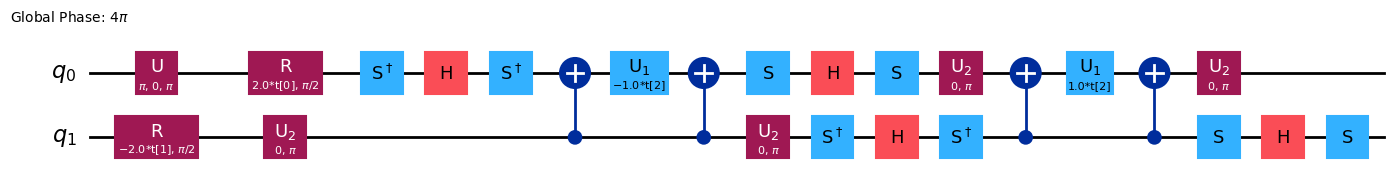

In [21]:
init_state = HartreeFock(
    num_spatial_orbitals=problem_reduced.num_spatial_orbitals,
    num_particles=problem_reduced.num_particles,
    qubit_mapper=parity_mapper,
)
ansatz_ucc = UCC(
    qubit_mapper=parity_mapper,
    num_particles=problem_reduced.num_particles,
    num_spatial_orbitals=problem_reduced.num_spatial_orbitals,
    excitations="sd",
    initial_state=init_state,
)
print("Number of parameters in UCC ansatz:", len(ansatz_ucc.parameters))
print("Depth of UCC ansatz:", ansatz_ucc.decompose().depth())
ansatz_ucc.decompose(reps=3).draw("mpl")

### Running VQE simulation with 4000 shots

In [22]:
shots, iterations = 4000, 125

backend = Aer()
estimator = Estimator()

counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)


ansatz = ansatz_ucc
spsa = SPSA(maxiter=iterations)
vqe = VQE(estimator, ansatz, optimizer=spsa, callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(operator=qubit_op_parity)
dev = result.eigenvalue.real - ref_value
print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}"
)

VQE on Aer qasm simulator (no noise): -1.86001
Delta from reference energy value is -0.00274


### Running VQE simulation with 10000 shots

In [ ]:
shots, iterations = 10_000, 125

backend = Aer()
estimator = Estimator()

counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)


ansatz = ansatz_ucc
spsa = SPSA(maxiter=iterations)
vqe = VQE(estimator, ansatz, optimizer=spsa, callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(operator=qubit_op_parity)
dev1 = np.abs(result.eigenvalue.real - ref_value)
print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}"
)

VQE on Aer qasm simulator (no noise): -1.86513
Delta from reference energy value is -0.00785


### Running VQE simulation with 100000 shots

In [ ]:
shots, iterations = 100_000, 125
backend = Aer()
estimator = Estimator()

counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)


ansatz = ansatz_ucc
spsa = SPSA(maxiter=iterations)
vqe = VQE(estimator, ansatz, optimizer=spsa, callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(operator=qubit_op_parity)
dev2 = result.eigenvalue.real - ref_value
print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}"
)

VQE on Aer qasm simulator (no noise): -1.85012
Delta from reference energy value is 0.00715


### Running VQE simulation with 500000 shots

In [25]:
shots, iterations = 500_000, 125

backend = Aer()
estimator = Estimator()

counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)


ansatz = ansatz_ucc
# ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(estimator, ansatz, optimizer=spsa, callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(operator=qubit_op_parity)
dev3 = result.eigenvalue.real - ref_value
print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}"
)

VQE on Aer qasm simulator (no noise): -1.85587
Delta from reference energy value is 0.00141


Text(0.5, 1.0, 'Deviation from exact solution')

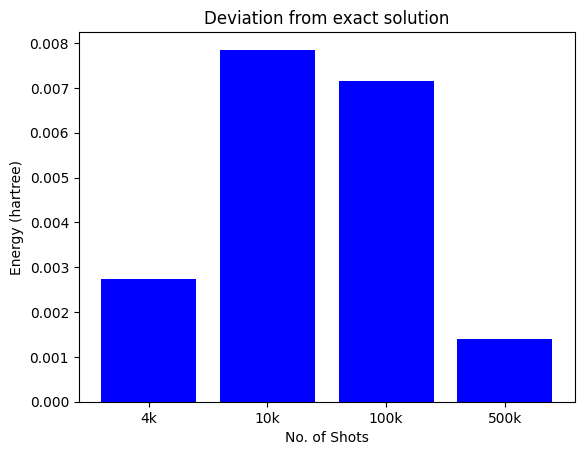

In [26]:
import matplotlib.pyplot as plt

deviation = [abs(dev), abs(dev1), dev2, dev3]
x_labels = ["4k", "10k", "100k", "500k"]

plt.bar(x_labels, deviation, color="blue")
plt.xlabel("No. of Shots")
plt.ylabel("Energy (hartree)")
plt.title("Deviation from exact solution")